# Case X.
Lauri Marjanen & Jesse Jyrälä, Team 10<br>
Neural Networks for Machine Learning Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

In [90]:
# Required libraries
import numpy as np
%pylab inline
import os
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.layers import Embedding, Dropout, Conv1D, GlobalAveragePooling1D, Dense, SimpleRNN

from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical




print(f'Tensorflow version {tf.__version__}')

Populating the interactive namespace from numpy and matplotlib
Tensorflow version 2.7.0


C:\ProgramData\Anaconda3\envs\Anaconda ML\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Data

In [91]:
train = pd.read_csv(os.getcwd() + '/input/drugsComTrain_raw.csv')
test = pd.read_csv(os.getcwd() + '/input/drugsComTest_raw.csv')

In [92]:
%%time

maxFeat = 5000
seqLen = 200

samples = train['review']
tokenizer = Tokenizer(maxFeat)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

wordIndx = tokenizer.word_index
data = pad_sequences(sequences,seqLen)

print("Token count: ", len(wordIndx))
print("Shape: ", data.shape)

Token count:  51429
Shape:  (161297, 200)
Wall time: 29.7 s


In [93]:
ratings = train['rating'].values
labels = 1.0*(ratings >= 8) + 1.0*(ratings >= 5)
hotLabels = to_categorical(labels)
print("Shape of lables", hotLabels.shape)


Shape of lables (161297, 3)


## MODEL

In [102]:
valSplit = 0.30
testSplit = 0.5
N1 = int(valSplit * data.shape[0])
N2 = int(testSplit * data.shape[0])
index = np.arange(data.shape[0])
np.random.shuffle(index)
data = data[index]
hotLabels = hotLabels[index]

trainData = data[:N1]
trainCat = hotLabels[:N1]
valData = data[N1:N2]
valCat = hotLabels[N1:N2]
testData =data[N2:]
testCat = hotLabels[N2:]

In [112]:
embeddedDing = 100

model = Sequential([
    Embedding(maxFeat +1, embeddedDing),
    Dropout(0.2),
    Conv1D(128,7, padding="valid", activation= "relu", strides=3),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(128,activation="relu"),
    Dense(3,activation="softmax")
])
model.compile(loss = 'categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 100)         500100    
                                                                 
 dropout_29 (Dropout)        (None, None, 100)         0         
                                                                 
 conv1d_15 (Conv1D)          (None, None, 128)         89728     
                                                                 
 global_average_pooling1d_12  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                     

In [96]:
EPOCHS = 5
VERBOSE = 1

In [113]:
%%time
hist= model.fit(trainData, trainCat,
                batch_size=128*2,
                epochs=EPOCHS,
                verbose=VERBOSE,
                validation_data=(valData,valCat)
                )

Epoch 1/5
190/190 [==============================] - 24s 119ms/step - loss: 0.8096 - acc: 0.6621 - val_loss: 0.7674 - val_acc: 0.6872
Epoch 2/5
190/190 [==============================] - 22s 117ms/step - loss: 0.6724 - acc: 0.7341 - val_loss: 0.7390 - val_acc: 0.7165
Epoch 3/5
190/190 [==============================] - 22s 116ms/step - loss: 0.6268 - acc: 0.7521 - val_loss: 0.6883 - val_acc: 0.7216
Epoch 4/5
190/190 [==============================] - 22s 116ms/step - loss: 0.5853 - acc: 0.7669 - val_loss: 0.6968 - val_acc: 0.7442
Epoch 5/5
190/190 [==============================] - 22s 116ms/step - loss: 0.5490 - acc: 0.7808 - val_loss: 0.6781 - val_acc: 0.7439
Wall time: 1min 52s


# Results and Discussion

The following results were achieved ...

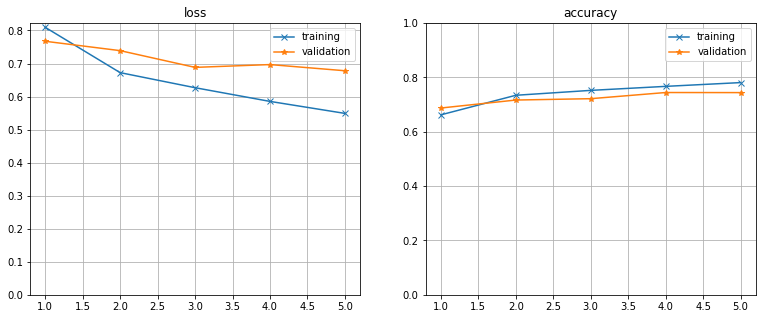

In [114]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure, subplot, plot, title, ylim, legend, grid

x_axis = np.arange(len(hist.history['loss'])) + 1


figure(figsize(13,5))
subplot(1,2,1)
plot(x_axis, hist.history['loss'], 'x-', label = 'training')
plot(x_axis, hist.history['val_loss'], '*-', label = 'validation')
title('loss')
ylim(0,)
legend()
grid()


subplot(1,2,2)
plot(x_axis, hist.history['acc'], 'x-', label = 'training')
plot(x_axis, hist.history['val_acc'], '*-', label = 'validation')

title('accuracy')
ylim(0,1.0)
legend()
grid()

In [115]:
result = model.evaluate(testData,testCat, verbose=VERBOSE)
print("Test accuracy: ", round(100 * result[1], 3 ))

2521/2521 [==============================] - 17s 7ms/step - loss: 0.6766 - acc: 0.7473
Test accuracy:  74.73


In [106]:
from sklearn.metrics import cohen_kappa_score

pred_labels = np.argmax(model.predict(testData),axis=1)
test_labels = np.argmax(testCat, axis = 1)

k = cohen_kappa_score(test_labels,pred_labels)
print("Chohen's kappa linear", k)

k = cohen_kappa_score(test_labels,pred_labels, weights='quadratic')
print("Chohen's kappa quad", k)

Chohen's kappa linear 0.5425124013372529
Chohen's kappa quad 0.6626748533600499


# Conclusions

To summarize we found out that ...